In [1]:
import vio_ort
import json
import matplotlib.pyplot as plt
import os
import cv2
from collections import defaultdict
import concurrent.futures
import threading

In [2]:
lat_VIO = []
lon_VIO = []

odometry = vio_ort.VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)

# Путь к папке
set_dir = '2025_1_16_15_43_35'
set_dir = '2024_12_15_15_31_8_num_3'
#TODO 2024_12_15_15_18_8_num_24 
# 500 корректных значений, 1200 ошибок Missing GNRMC or VIO в json
#TODO 2024_12_15_15_31_8_num_3 
# 3000 корректных значений
# значительные различия между GPS и VIO
#TODO 2024_12_15_15_31_8_num_5 
# 200 корректных значений, 700 ошибок Image not found

# Получение всех файлов с расширением .json
json_files = [f for f in os.listdir(set_dir) if f.endswith('.json')]

# Сортировка файлов по имени
json_files.sort()

# start_json = "1730798575417.json"
start = 30
count_json = 600

start = 0
count_json = len(json_files)

start = 1000
count_json = 2

lat_VIO = []
lon_VIO = []

lat_GPS = []
lon_GPS = []

In [3]:
# Инициализация структуры для ошибок
fails_collect = defaultdict(lambda: {'num': 0, 'files': []})

In [4]:
lock = threading.Lock()

In [5]:
def register_error(error_type, filename):
    with lock:
        if error_type not in fails_collect:
            fails_collect[error_type] = {'num': 0, 'files': []}
        fails_collect[error_type]['num'] += 1
        fails_collect[error_type]['files'].append(filename)

In [6]:
def process_file(filename):
    try:
        with open(f'{set_dir}/{filename}', 'r') as file:
            data = json.load(file)

        if 'GNRMC' not in data or 'VIO' not in data:
            register_error("Missing GNRMC or VIO", filename)
            return

        if data['GNRMC'].get('status') != 'A':
            register_error("GNRMC status not 'A'", filename)
            return

        img_path = f"{set_dir}/{os.path.splitext(filename)[0]}.jpg"
        if not os.path.exists(img_path):
            register_error("Image not found", filename)
            return

        image = cv2.imread(img_path)
        if image is None:
            register_error("Failed to load image", filename)
            return

        try:
            with open("debug_output.txt", "a") as f:
                f.write(f"[VIO] Attempting to add trace point for image: {image}, data: {data}\n")
            
            result_vio = odometry.add_trace_pt(image, data)
            
            if 'lat' not in result_vio or 'lon' not in result_vio:
                with open("debug_output.txt", "a") as f:
                    f.write(f"[VIO] Missing 'lat' or 'lon' in result: {result_vio}\n")
                register_error("VIO result missing 'lat' or 'lon'", filename)
                return

            with lock:
                lat_VIO.append(result_vio['lat'])
                lon_VIO.append(result_vio['lon'])

        except Exception as e:
            with open("debug_output.txt", "a") as f:
                f.write(f"[VIO] Error occurred: {str(e)}\n")
            register_error("VIO processing error", filename)
            return

        try:
            with lock:
                lat_GPS.append(data['GNRMC'].get('lat', 0.0))
                lon_GPS.append(data['GNRMC'].get('lon', 0.0))
        except KeyError:
            register_error("GPS data missing", filename)
    except json.JSONDecodeError:
        register_error("JSON decode error", filename)
    except Exception:
        register_error("Processing error", filename)

In [7]:
workers = 6

In [8]:
with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as executor:
        executor.map(process_file, json_files[start:start + count_json])

При 2 потоках уходит 4m2s

При 4 потоках уходит 1m36s, 1m29s, 1m32s, 1m34s

При 6 потоках уходит 1m27sб 1m25s, 1m31s, 1m31s

При 8 потоках уходит 1m30s, 1m30s, 1m33s, 1m31s

При 16 потоках уходит 2m1s

При добавлении JIT-компиляции создает ошибку VIO processing error - 3300 occurrences
, и на все уходит 55s, 54s, 56s

In [9]:
# Вывод отчетности
print("\nError Report:")
for error_type, error_info in fails_collect.items():
    print(f"{error_type} - {error_info['num']} occurrences")
    print(f"Files: {', '.join(error_info['files'])}")
    print()


Error Report:


In [10]:
print(f'GPS lat: {lat_GPS[0]}')
print(f'VIO lat: {lat_VIO[0]}')

GPS lat: 54.8894156667
VIO lat: 54.889668


In [11]:
print(f'GPS lon: {lon_GPS[0]}')
print(f'VIO lon: {lon_VIO[0]}')

GPS lon: 83.1257365
VIO lon: 83.1258973333


In [12]:
print(len(lat_GPS))
print(len(lat_VIO))

2
2


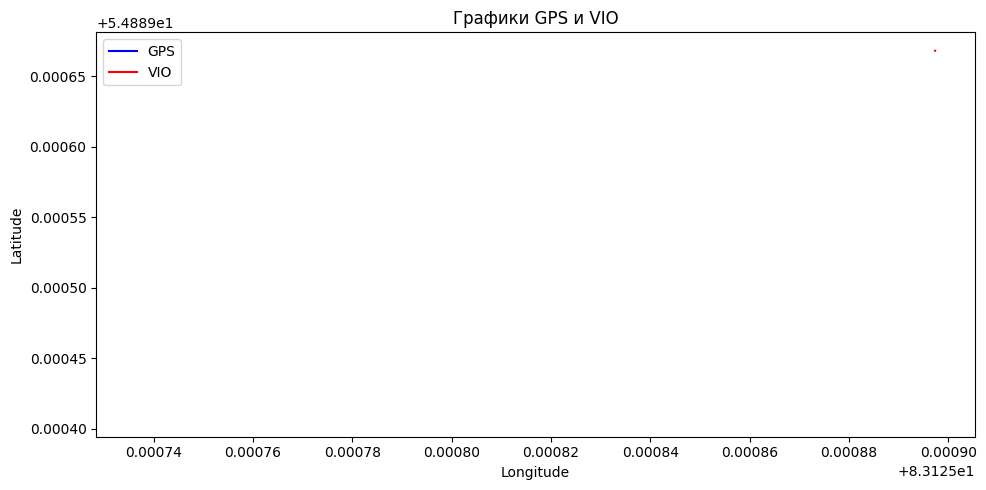

In [13]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()

# Create figure and axis
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))
copy_lat_GPS = [ - x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

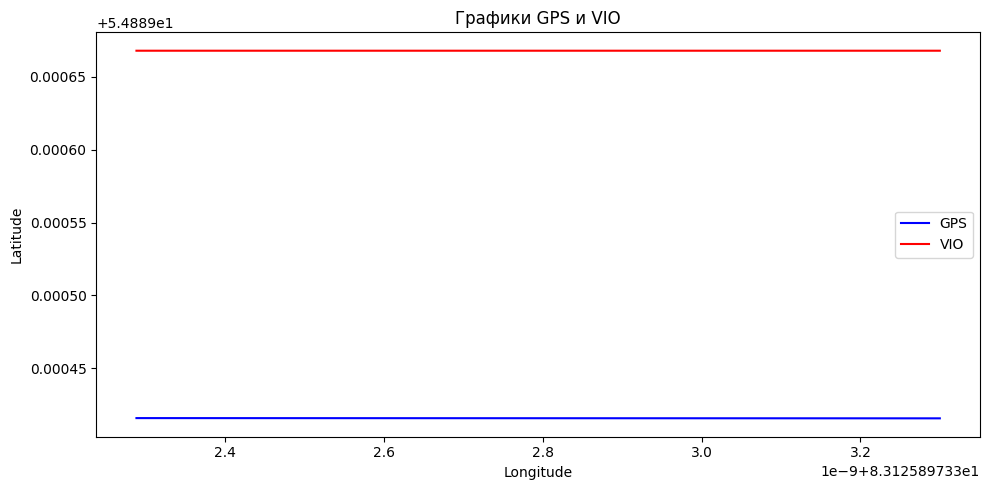

In [14]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_VIO.copy()

# Create figure and axis
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))
# copy_lat_GPS = [ - x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()